In [41]:
from load_data import load_all_results, school_names
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [42]:
results_df = load_all_results()

# we need to go through and find the number of freshmen known by upperclassmen in each school
from load_data import load_school
true_updated = {}
for s in school_names:
    A, df = load_school(s)
    freshmen = df[df.year == 2009].index
    upperclassmen = df[(df.year >= 2006) & (df.year <= 2008)].index

    has_upperclassman_friend = A[freshmen, :][:, upperclassmen].sum(axis=1) > 0
    true_updated[s] = int(has_upperclassman_friend.sum())

true_updated = results_df['school'].map(lambda x: true_updated.get(x, x))
print(true_updated / results_df.true)

# replace these in df_all
results_df['true_old'] = results_df['true']
results_df['true'] = true_updated

0         0.935772
1         0.935772
2         0.935772
3         0.935772
4         0.935772
            ...   
191095    0.930477
191096    0.930477
191097    0.930477
191098    0.930477
191099    0.930477
Length: 191100, dtype: float64


In [43]:
df_all = results_df

In [44]:
df = df_all[df_all.type == 'upperclassmen']

In [45]:
df.head()

,measure,grade,value,true,type,school,year,true_old
1050,joint-mention,1,1040.276889,1049,upperclassmen,American75,NaN,1121
1051,chao 1987,1,141.444444,1049,upperclassmen,American75,NaN,1121
1052,PIMLE,1,357.100844,1049,upperclassmen,American75,NaN,1121
1053,MLE,1,160.859360,1049,upperclassmen,American75,NaN,1121
1054,dombrowski,1,NaN,1049,upperclassmen,American75,NaN,1121


In [46]:
# confidence intervals (5% and 95%)
M = df.groupby('measure')[['value', 'true']].apply(lambda x: (x.value / x.true).mean())
ci_5 = df.groupby('measure')[['value', 'true']].apply(lambda x: (x.value / x.true).quantile(0.05))
ci_95 = df.groupby('measure')[['value', 'true']].apply(lambda x: (x.value / x.true).quantile(0.95))

# create a metric that flips the way we measure...
# "min-normalized error"
symmetrize_above = True
def m_norm(x):
    y = x.value / x.true
    ixG = y > 1
    ixL = y < 1

    if symmetrize_above:
      y[ixG] = y[ixG] - 1
      y[ixL] = 1/y[ixL] - 1
    else: 
      y[ixG] = 1 - 1/y[ixG]
      y[ixL] = 1 - y[ixL]
    return y

Mabs = df.groupby('measure')[['value', 'true']].apply(lambda x: m_norm(x).mean())
ci_5abs = df.groupby('measure')[['value', 'true']].apply(lambda x: m_norm(x).quantile(0.05))
ci_95abs = df.groupby('measure')[['value', 'true']].apply(lambda x: m_norm(x).quantile(0.95))

# experimental log scale
Mlog = df.groupby('measure')[['value', 'true']].apply(lambda x: np.exp(np.abs(np.log(x.value / x.true)).mean()) - 1)
ci_5log = df.groupby('measure')[['value', 'true']].apply(lambda x: np.exp(np.abs(np.log(x.value / x.true).quantile(0.95))) - 1)
ci_95log = df.groupby('measure')[['value', 'true']].apply(lambda x: np.exp(np.abs(np.log(x.value / x.true).quantile(0.05))) - 1)

c:\envs\data\Lib\site-packages\numpy\lib\_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\envs\data\Lib\site-packages\numpy\lib\_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\envs\data\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\envs\data\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\envs\data\Lib\site-packages\numpy\lib\_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\envs\data\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\envs\data\Lib\site-packages\numpy\lib\_function_b

In [47]:
# Finally, we see that  Lanumteang et al.’s (2011) lower bound does substantially better than Scale-Up, but worse than Joint-Referral. This estimate of the lower bound can also wildly overestimate the true value in rare cases.

#what quantile of the lower bound is greater than 2x the true value? 4x?
L = df[df.measure == 'lanumteang 2011']
N_2x = sum(L.value > 2 * L.true)
N_4x = sum(L.value > 4 * L.true)
N_5x = sum(L.value > 5 * L.true)
N_8x = sum(L.value > 8 * L.true)
N_tot = len(L)

print(f"{N_2x / N_tot:.1%}")
print(f"{N_4x / N_tot:.1%}")
print(f"{N_5x / N_tot:.1%}")
print(f"{N_8x / N_tot:.1%}")

1.2%
1.0%
1.0%
0.6%


In [48]:
from IPython.display import Markdown, display

display(Markdown(
    f"Freshmen in these 100 schools have just 12.3% the number of Facebook friendships to upperclassmen, on average, as do upperclassmen. "
    f"So, it should not be surprising that Scale-Up significantly underestimates the number of freshmen known by upperclassmen. "
    f"Estimates from the Scale-Up method were on average just {M['MLE']:0.1%} of the true population size, "
    f"with the middle 90% of estimates ranging from {ci_5['MLE']:0.1%} to {ci_95['MLE']:0.1%}. "
    f"This is because network scale-up relies on visibility, and underrepresented groups like freshmen appear less frequently in ego networks.\n\n"
    
    f"By contrast, the joint-referral method developed in this paper gives a much more accurate estimate: on average {M['joint-mention']:0.1%} of the true population size, "
    f"with the middle 90% of estimates ranging from {ci_5['joint-mention']:0.1%} to {ci_95['joint-mention']:0.1%}. "
    f"Instead of relying on average visibility like Scale-Up, joint-referral depends on the parameter "
    f"$C = 1 + V/M^2$ being similar between groups. For freshmen, C is on average 58% that of upperclassman groups. "
    f"Crucially, C varies much less than M when comparing freshmen to upperclassmen in these schools, making the joint-referral approach more stable and less biased.\n\n"
    
    f"Lanumteang et al.’s (2011) lower bound method also performs better than Scale-Up, with an average estimate of {M['lanumteang 2011']:0.1%} of the true population size "
    f"and a middle 90% range from {ci_5['lanumteang 2011']:0.1%} to {ci_95['lanumteang 2011']:0.1%}. "
    f"However, this method can still produce extreme overestimates: in {N_2x / N_tot:.1%} of cases the estimate was more than twice the true value, "
    f"in {N_4x / N_tot:.1%} it was more than four times too large, and in {N_5x / N_tot:.1%} of schools, the estimate exceeded five times the true size. "
    f"Rare but severe overestimation is a known limitation of this lower bound approach."
))


Freshmen in these 100 schools have just 12.3% the number of Facebook friendships to upperclassmen, on average, as do upperclassmen. So, it should not be surprising that Scale-Up significantly underestimates the number of freshmen known by upperclassmen. Estimates from the Scale-Up method were on average just 12.9% of the true population size, with the middle 90% of estimates ranging from 5.5% to 27.7%. This is because network scale-up relies on visibility, and underrepresented groups like freshmen appear less frequently in ego networks.

By contrast, the joint-referral method developed in this paper gives a much more accurate estimate: on average 66.5% of the true population size, with the middle 90% of estimates ranging from 29.3% to 108.0%. Instead of relying on average visibility like Scale-Up, joint-referral depends on the parameter $C = 1 + V/M^2$ being similar between groups. For freshmen, C is on average 58% that of upperclassman groups. Crucially, C varies much less than M when comparing freshmen to upperclassmen in these schools, making the joint-referral approach more stable and less biased.

Lanumteang et al.’s (2011) lower bound method also performs better than Scale-Up, with an average estimate of 34.9% of the true population size and a middle 90% range from 6.4% to 77.6%. However, this method can still produce extreme overestimates: in 1.2% of cases the estimate was more than twice the true value, in 1.0% it was more than four times too large, and in 1.0% of schools, the estimate exceeded five times the true size. Rare but severe overestimation is a known limitation of this lower bound approach.

In [ ]:
iqr = df.groupby('measure')[['value', 'true']].apply(lambda x: ((x.value / x.true).quantile(0.25), (x.value / x.true).quantile(0.75)))
display(Markdown(
    f"Figure 1 shows that in this situation, the joint-referral estimates were generally much better than the other estimates. "
    f"The interquartile range of estimates from Joint-Referrals went from {iqr['joint-mention'][0]:0.0%} to {iqr['joint-mention'][1]:0.0%} of the true scores. "
    f"The interquartile range for Scale-Up estimates went from {iqr['MLE'][0]:0.0%} to {iqr['MLE'][1]:0.0%} of the true values. "
    f"The interquartile range for the lower bounds went from {iqr['lanumteang 2011'][0]:0.0%} to {iqr['lanumteang 2011'][1]:0.0%} of the true values."
))

Figure 1 shows that in this situation, the joint-referral estimates were generally much better than the other estimates. The interquartile range of estimates from Joint-Referrals went from 49% to 82% of the true scores. The interquartile range for Scale-Up estimates went from 8% to 15% of the true values. The interquartile range for the lower bounds went from 10% to 31% of the true values.

In [9]:
from IPython.display import Markdown, display

display(Markdown(
    f"### Comparison of Estimation Methods\n"
    f"| Method                        | Mean Symmetric Relative Error | Middle 90% Range           |\n"
    f"|------------------------------|-------------------------------:|----------------------------|\n"
    f"| Joint-Referral (this paper)  | {Mabs['joint-mention']:0.1%}      | {ci_5abs['joint-mention']:0.1%} - {ci_95abs['joint-mention']:0.1%} |\n"
    f"| Scale-Up (Killworth et al. 1998)  | {Mabs['MLE']:0.1%}                | {ci_5abs['MLE']:0.1%} - {ci_95abs['MLE']:0.1%} |\n"
    f"| Lower Bound (Lanumteang et al., 2011) | {Mabs['lanumteang 2011']:0.1%}      | {ci_5abs['lanumteang 2011']:0.1%} - {ci_95abs['lanumteang 2011']:0.1%} |"
))


### Comparison of Estimation Methods
| Method                        | Mean Symmetric Relative Error | Middle 90% Range           |
|------------------------------|-------------------------------:|----------------------------|
| Joint-Referral (this paper)  | 87.6%      | 4.4% - 241.7% |
| Scale-Up (Killworth et al. 1998)  | 882.2%                | 261.5% - 1705.2% |
| Lower Bound (Lanumteang et al., 2011) | 613.6%      | 43.6% - 1475.5% |

In [10]:
from IPython.display import Markdown, display

display(Markdown(
    f"### Comparison of Estimation Methods\n"
    f"| Method                        | Mean Symmetric Relative Error | Middle 90% Range           |\n"
    f"|------------------------------|-------------------------------:|----------------------------|\n"
    f"| Joint-Referral (this paper)  | {Mlog['joint-mention']:0.1%}      | {ci_5log['joint-mention']:0.1%} - {ci_95log['joint-mention']:0.1%} |\n"
    f"| Scale-Up (Killworth et al. 1998)  | {Mlog['MLE']:0.1%}                | {ci_5log['MLE']:0.1%} - {ci_95log['MLE']:0.1%} |\n"
    f"| Lower Bound (Lanumteang et al., 2011) | {Mlog['lanumteang 2011']:0.1%}      | {ci_5log['lanumteang 2011']:0.1%} - {ci_95log['lanumteang 2011']:0.1%} |"
))


### Comparison of Estimation Methods
| Method                        | Mean Symmetric Relative Error | Middle 90% Range           |
|------------------------------|-------------------------------:|----------------------------|
| Joint-Referral (this paper)  | 66.9%      | 8.0% - 241.7% |
| Scale-Up (Killworth et al. 1998)  | 779.1%                | 261.5% - 1705.2% |
| Lower Bound (Lanumteang et al., 2011) | 460.9%      | 28.9% - 1470.5% |

# what about Crat across schools?

In [11]:
def compute_c(d):
    d = d[d > 0]
    M = d.mean()
    V = d.var()
    C = 1 + V/M**2
    return C

crats = {}
mdegs = {}
for s in school_names:
    A, df = load_school(s)
    freshmen = df[df.year == 2009].index
    upperclassmen = df[(df.year >= 2006) & (df.year <= 2008)].index

    df = df[df['student/faculty'] == 1]

    # get degree distributions for freshmen and for each year upperclassman
    freshmen = df[df.year == 2009].index

    d = A[freshmen, :][:, upperclassmen].sum(axis=1)
    fC = compute_c(d)
    mdegs[s, 2009] = d[d>0].mean()

    years = [2006, 2007, 2008]
    
    for y in years:
        ix = df[df.year == y].index
        d = A[ix, :][:, upperclassmen].sum(axis=1)
        assert d.shape[0] == len(ix)
        
        Crat = compute_c(d) / fC

        crats[s, y] = Crat
        mdegs[s, y] = d[d>0].mean()


In [12]:
# visibility
mrats = [mdegs[s, 2009] / mdegs[s, y] for y in [2006, 2007, 2008] for s in school_names]
mrats = np.array(mrats)

pd.DataFrame(mrats).describe()

,0
count,300.000000
mean,0.122943
std,0.059504
min,0.038626
25%,0.078076
50%,0.105779
75%,0.148519
max,0.374543


0.5798418091477303 0.12294337615199145


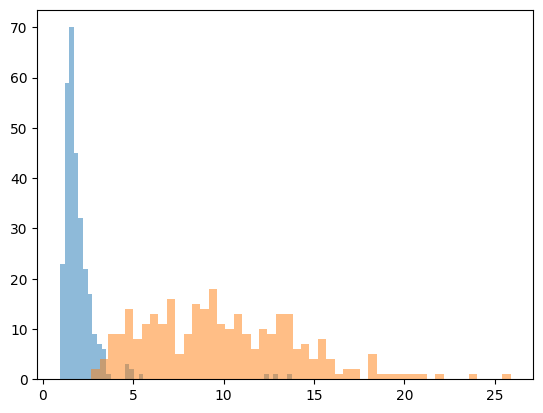

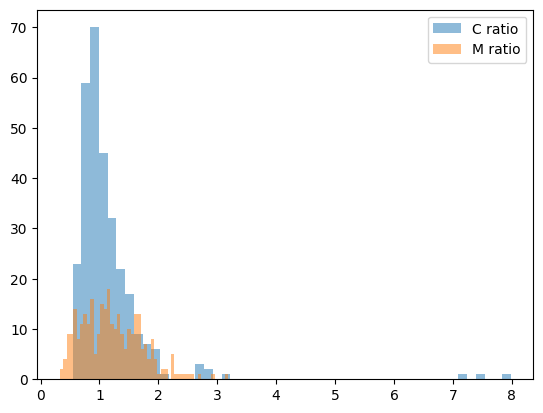

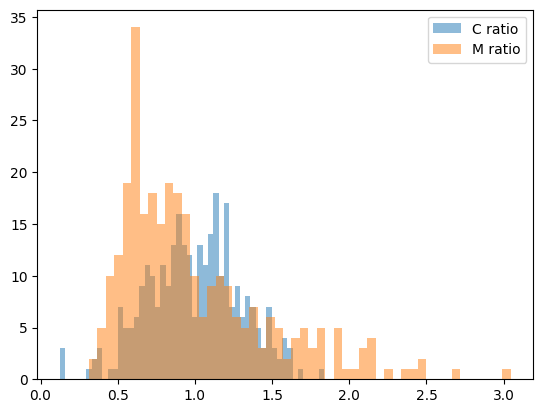

In [39]:
cr = np.array(list(crats.values()))
mr = np.array(list(mrats))

print(cr.mean(), mr.mean())

plt.hist(1/cr, bins=50, alpha=0.5, label='C ratio')
plt.hist(1/mr, bins=50, alpha=0.5, label='M ratio')

plt.show()

plt.hist(cr.mean()/cr, bins=50, alpha=0.5, label='C ratio')
plt.hist(mr.mean()/mr, bins=50, alpha=0.5, label='M ratio')

plt.legend()
plt.show()

plt.hist( cr/cr.mean(), bins=50, alpha=0.5, label='C ratio')
plt.hist( mr/mr.mean(), bins=50, alpha=0.5, label='M ratio')
plt.legend()
plt.show()

In [32]:
print(pd.DataFrame(1/cr).describe())

                0
count  300.000000
mean     2.001352
std      1.302322
min      0.937568
25%      1.432563
50%      1.700609
75%      2.174039
max     13.767937


In [33]:
print( pd.DataFrame(1/mr).describe() )

                0
count  300.000000
mean     9.887290
std      4.162942
min      2.669919
25%      6.733132
50%      9.453704
75%     12.808140
max     25.889130


In [35]:
(1/cr).std(), (1/mr).std()

(np.float64(1.3001500933816323), np.float64(4.155998087832803))

In [27]:
mr.mean()

np.float64(1.0)

In [24]:
np.abs(cr - cr.mean()).mean(), np.abs(mr - mr.mean()).mean()

(np.float64(0.24582342928765294), np.float64(0.37751927249784445))

In [49]:
cs = np.array(list(crats.values()))

# describe the distribution of cs in a table
pd.DataFrame(cs).describe()


,0
count,300.000000
mean,0.579785
std,0.175104
min,0.071676
25%,0.459407
50%,0.587660
75%,0.697247
max,1.065970


In [50]:
# now let's bring this into the results dataframe

results_df['crat'] = results_df.school.map(lambda x: np.mean([
    crats[x,y]
    for y in [2006, 2007, 2008]
]))

In [ ]:
results_df

,measure,grade,value,true,type,school,crat
0,joint-mention,1,1287.155366,1051,everyone,American75,0.856508
1,chao 1987,1,132.181818,1051,everyone,American75,0.856508
2,PIMLE,1,5897.066753,1051,everyone,American75,0.856508
3,MLE,1,1198.352850,1051,everyone,American75,0.856508
4,dombrowski,1,1111.370370,1051,everyone,American75,0.856508
...,...,...,...,...,...,...,...
176395,PIMLE,3,155.654897,1169,upperclassmen,Yale4,0.416615
176396,MLE,3,106.260739,1169,upperclassmen,Yale4,0.416615
176397,dombrowski,3,NaN,1169,upperclassmen,Yale4,0.416615
176398,lanumteang 2011,3,191.250000,1169,upperclassmen,Yale4,0.416615


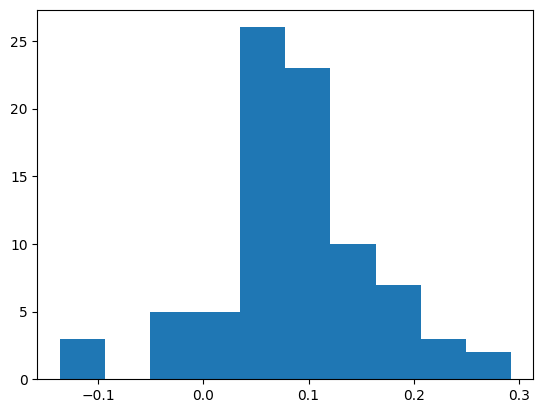

In [57]:
r = results_df

r = r[(r.type == 'upperclassmen') & (r.measure == 'joint-mention')]
diff_by_school = r.groupby('school')[['value', 'true', 'crat']].apply(lambda x: np.mean((x.value / x.true) - x.crat))

plt.hist(diff_by_school, bins=10);


In [54]:
np.mean((r.value / r.true) - r.crat)

0.08702699998840202

# how many joint mentions do we get?

In [ ]:
from scaleup import ScaleUp, Sample
from load_data import load_school, school_names
A, df = load_school(school_names[0])

freshmen = df[df.year == 2009].index
upperclassmen = df[(df.year >= 2006) & (df.year <= 2008)].index

groups = [
  freshmen,
  *[
    df[df.year == y].index
    for y in [2006, 2007, 2008]
  ]
]

# remove the out-edges from freshmen
A[freshmen, :] = 0

In [2]:
# create the scale-up
s = ScaleUp(A, groups, [])

In [14]:
from collections import defaultdict
ki = defaultdict(list)
for _ in range(100):
  samp = Sample(s, 250)
  for k in range(1, 11):
    ki[k].append(samp.count_k_mentioned(0, k, 'count'))

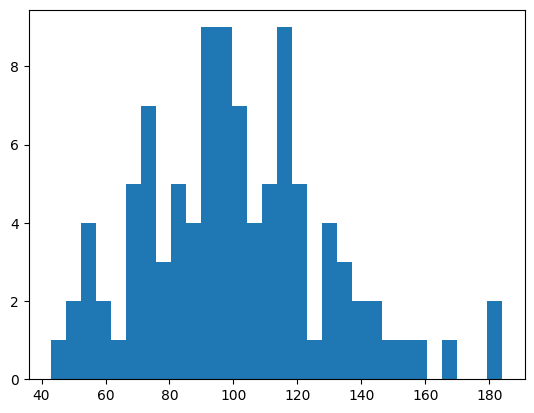

In [23]:
from matplotlib import pyplot as plt
import numpy as np
plt.hist(np.array(ki[2]) + np.array(ki[3]) + np.array(ki[4]) + np.array(ki[5]) + np.array(ki[6]) + np.array(ki[7]) + np.array(ki[8]) + np.array(ki[9]) + np.array(ki[10]), bins=30);

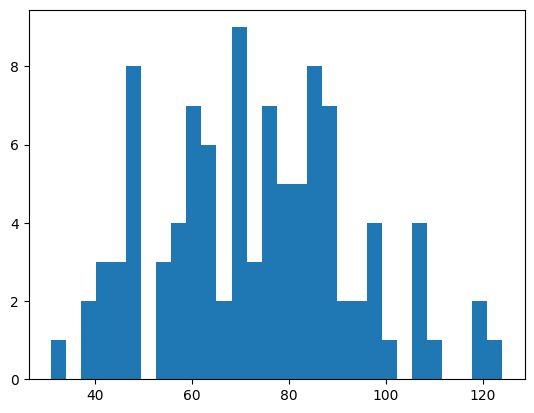

In [22]:
plt.hist(np.array(ki[2]), bins=30);